## Deevio Coding Challenge | EDA and model training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import imgaug as ia
import imgaug.augmenters as iaa
import pickle5 as pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.morphology import remove_small_objects

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras import backend as K
#check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Utilities

In [38]:
def plot_history(history):
    """plot model history"""
    plt.figure()
    plt.plot(history.history['val_accuracy'], 
             color='green', 
             label='Validation accuracy')
    plt.plot(history.history['accuracy'], 
             color='blue', 
             label='Training accuracy')
    plt.title('Training and validation accuracy across epochs')
    plt.legend()
    plt.figure()
    plt.plot(history_01.history['val_loss'], 
             color='green', 
             label='Validation loss')
    plt.plot(history_01.history['loss'], 
             color='blue', 
             label='Training loss')
    plt.title('Training and validation loss across epochs')
    plt.legend()

## EDA

In [3]:
#load image names
df_good = pd.read_csv('nailgun/good.txt', sep=" ", header=None)
df_good['good'] = 1
df_bad = pd.read_csv('nailgun/bad.txt', sep=" ", header=None)
df_bad['good'] = 0
df_label = pd.concat([df_good, df_bad])
df_label.reset_index(drop=True, inplace=True)
df_label.rename(columns={0: "ImageId"}, inplace=True)

In [4]:
df_label.head(3)

,ImageId,good
0,1522072665_good.jpeg,1
1,1522072726_good.jpeg,1
2,1522072743_good.jpeg,1


In [5]:
print("No. of good images:", df_good.shape[0])
print("No. of bad images:", df_bad.shape[0])

No. of good images: 99
No. of bad images: 99


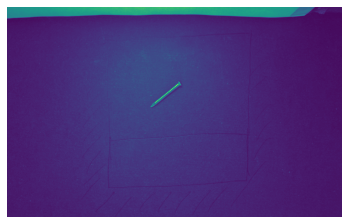

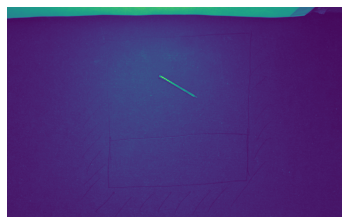

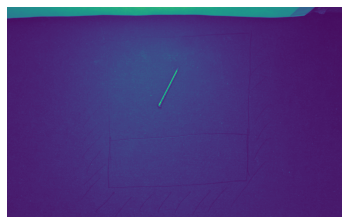

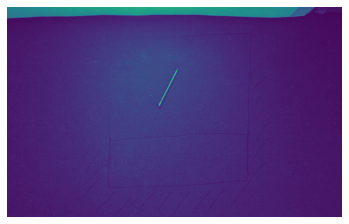

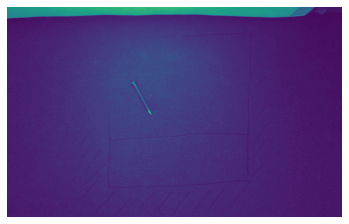

In [6]:
for i in range(5):
    img = cv2.imread("nailgun/good/"+df_good.iloc[i,0], cv2.IMREAD_GRAYSCALE)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

__The nails are placed within the drawn box. The images can be cropped to only include the box so that the images have a smaller size without losing any information.__

__The cropped image will be cropped with a tolerance, to a size that is slightly larger than the drawn bounding box, in case the worker accidentally placed the nail at the edge of the drawn box.__

__Image are resized to 224x224 to fit in the pretrained networks.__

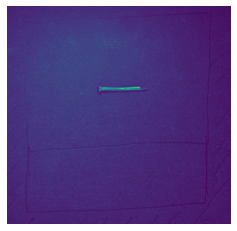

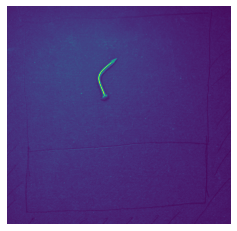

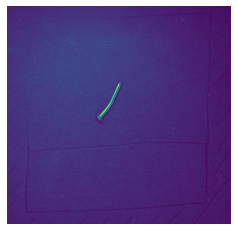

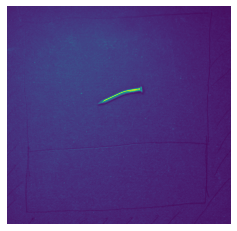

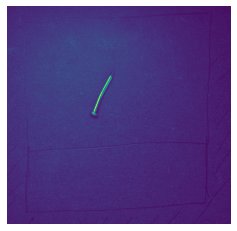

In [7]:
for i in range(5):
    img = cv2.imread("nailgun/bad/"+df_bad.iloc[i,0], cv2.IMREAD_GRAYSCALE)
    img = img[125:1100,500:1500]
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

__Image can be cropped even further to preserve even more information about the nail. The nail is usually the brightest object in the image. By calculating the average location of the brightest pixels, it is very likely the location is somewhere at the nail.__

__Image are filtered with a threshold to remove noise. The threshold is calculated per image due to the different lighting of each image.__

__Small objects are removed to further remove noise.__

__Image is resized to 224x224 to fit into the pretrained neural net.__

G:\Users\win-times-win\Anaconda3\envs\deevio\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


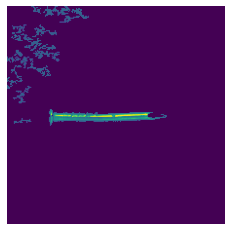

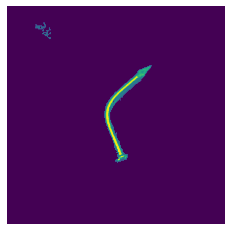

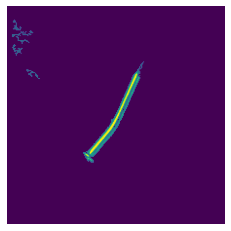

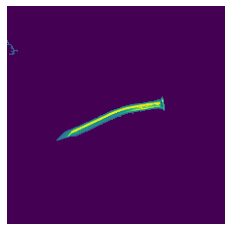

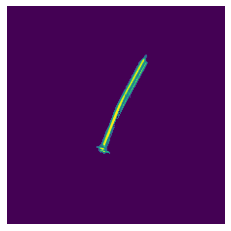

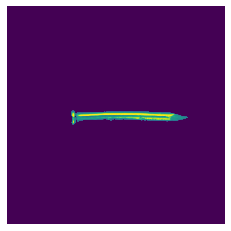

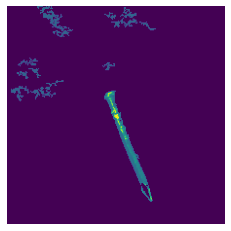

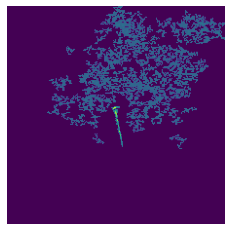

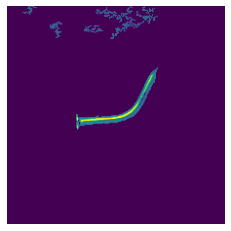

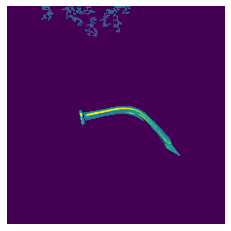

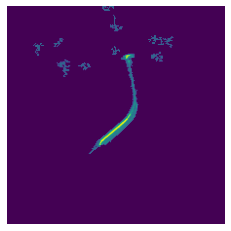

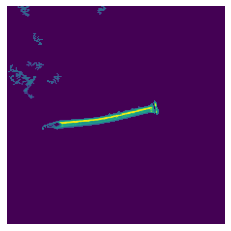

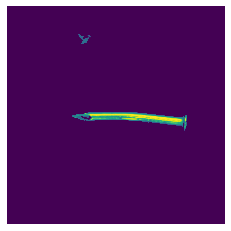

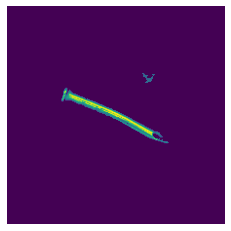

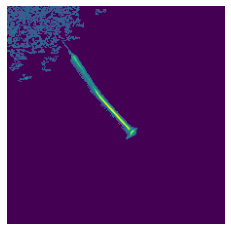

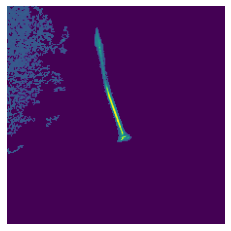

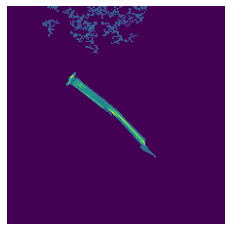

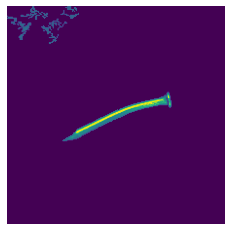

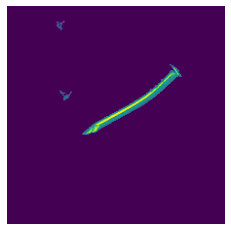

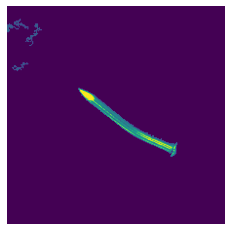

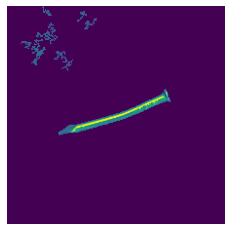

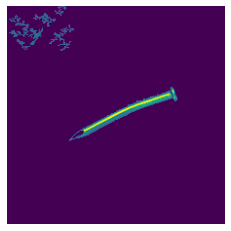

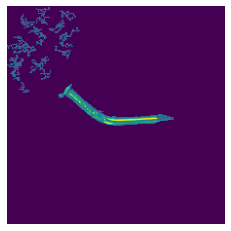

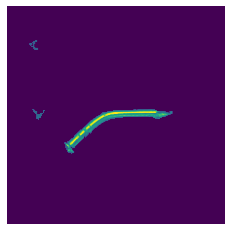

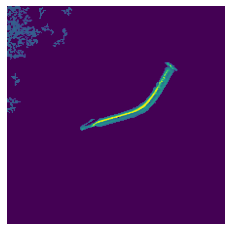

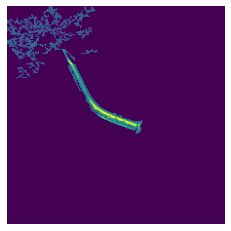

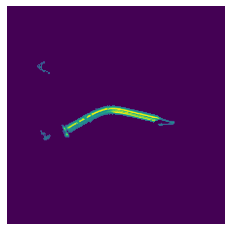

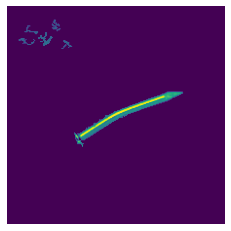

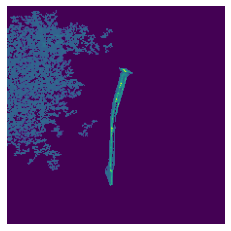

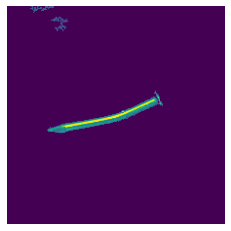

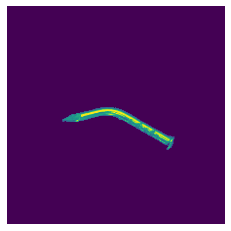

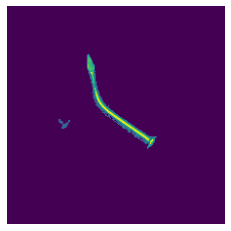

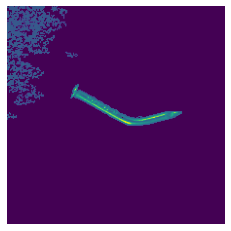

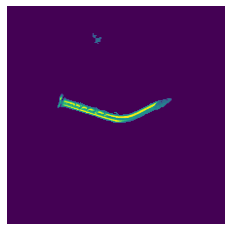

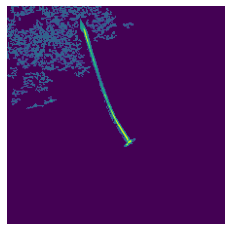

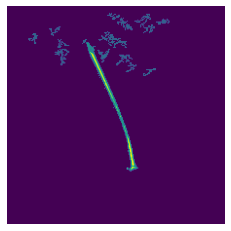

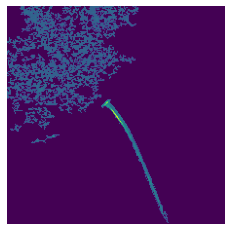

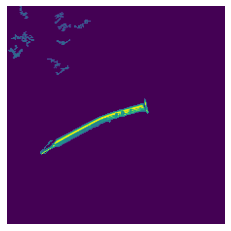

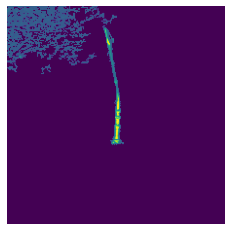

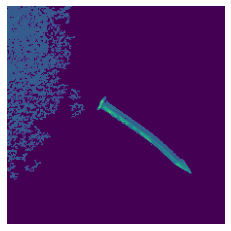

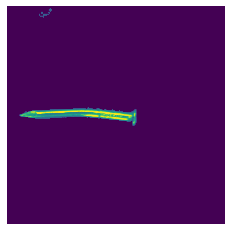

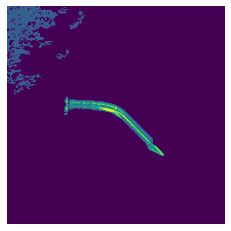

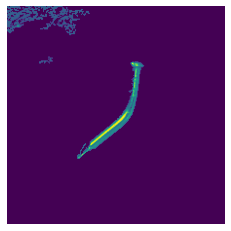

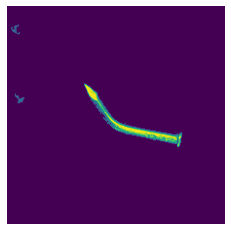

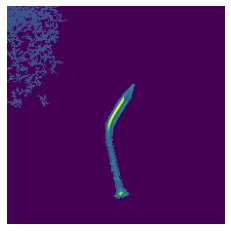

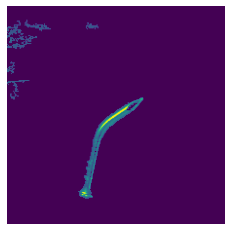

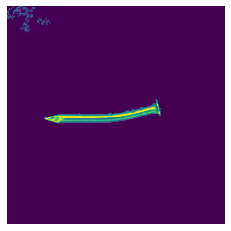

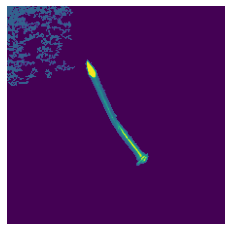

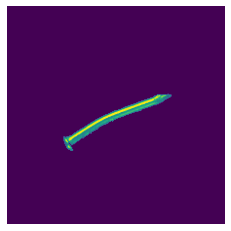

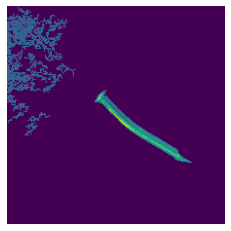

In [8]:
for i in range(50):
    img = cv2.imread("nailgun/bad/"+df_bad.iloc[i,0], cv2.IMREAD_GRAYSCALE)
    img = img[125:1100,500:1500]
    #find the average location of the top 20 brightest pixels
    sort_image = np.dstack(np.unravel_index(np.argsort(img[:,:].ravel()), (975, 1000)))
    sort_x_avg = int(np.around(np.average(sort_image[:,-20:-1,0])))
    sort_y_avg = int(np.around(np.average(sort_image[:,-20:-1,1])))

    if sort_x_avg < 200:
        sort_x_avg = 200
    elif sort_x_avg + 200 > 975:
        sort_x_avg = 975-200
    if sort_y_avg < 200:
        sort_y_avg = 200
    elif sort_y_avg + 200> 1000:
        sort_y_avg = 1000-200

    img = img[sort_x_avg-200:sort_x_avg+200,sort_y_avg-200:sort_y_avg+200]
    img = cv2.resize(img, (224, 224))
    
    #add image threshold and remove small objects
    threshold = np.average(img) + np.std(img)*0.75
    pred_temp = img.copy() 
    cnd = (img[:] >= threshold)
    pred_temp[cnd] = 1
    cnd = (img[:] < threshold)
    pred_temp[cnd] = 0
    pred_temp=pred_temp.astype('bool')
    pred_temp = remove_small_objects(pred_temp, 30, connectivity=2, in_place=True)
    img = np.multiply(img, pred_temp)
    img = np.array(img, dtype=np.float32)
    #normalize image
    img /= 255

    plt.figure()
    plt.axis('off')
    plt.imshow(img)

## Data Generator

This data generator is copied from my final project with some modifications. A Keras  ImageDataGenerator will be a simpler choice. A customer data generator is chosen because it has already been written and it can easily be modifified.

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, labels, image_dir, batch_size=32,
              image_h=224, image_w=224, preprocess=None, shuffle=False):
        self.list_ids = list_ids
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_h = image_h
        self.image_w = image_w
        self.preprocess = preprocess
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """number of batches per epoch"""
        return int(np.floor(len(self.list_ids)) / self.batch_size)

    def on_epoch_end(self):
        """update ended after each epoch"""
        self.indexes = np.arange(len(self.list_ids))
        #shuffle images for training more evenly
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids_temp):
        """process X and y to be returned to __getitem__"""
        X = np.empty((self.batch_size, self.image_h, self.image_w, 3))
        y = np.empty(self.batch_size)
        for i,image_id in enumerate(list_ids_temp):
            
            #modify path depending on 
            if self.labels[self.labels['ImageId']==image_id]['good'].iloc[0] == 0:
                image_path = os.path.join(self.image_dir, "bad")
            else:
                image_path = os.path.join(self.image_dir, "good")
            image_path = os.path.join(image_path, image_id)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = image[125:1100,500:1500]
            #find the location of nail by finding the 
            #average location of the top 20 brightest pixels
            sort_image = np.dstack(np.unravel_index(np.argsort(image[:,:].ravel()), (975, 1000)))
            sort_x_avg = int(np.around(np.average(sort_image[:,-20:-1,0])))
            sort_y_avg = int(np.around(np.average(sort_image[:,-20:-1,1])))
            if sort_x_avg < 200:
                sort_x_avg = 200
            elif sort_x_avg + 200 > 975:
                sort_x_avg = 975-200
            if sort_y_avg < 200:
                sort_y_avg = 200
            elif sort_y_avg + 200> 1000:
                sort_y_avg = 1000-200
            image = image[sort_x_avg-200:sort_x_avg+200,sort_y_avg-200:sort_y_avg+200]
            image = cv2.resize(image, (self.image_w, self.image_h))
            
            #image threshold different for each image 
            #due to different lighting throughout the day
            threshold = np.average(image) + np.std(image)*0.75
            pred_temp = image.copy() 
            cnd = (image[:] >= threshold)
            pred_temp[cnd] = 1
            cnd = (image[:] < threshold)
            pred_temp[cnd] = 0
            pred_temp=pred_temp.astype('bool')
            pred_temp = remove_small_objects(pred_temp, 40, connectivity=2, in_place=True)
            image = np.multiply(image, pred_temp)
            image = np.array(image, dtype=np.float32)
            
            #normalize image
            image /= 255

            #image augmentation
            seq = iaa.Sequential([
                iaa.Fliplr(0.5),
                iaa.Affine(
                    rotate=(0, 360),
                )
            ], random_order=True) # apply augmenters in random order
            
            image = seq(images=image)
            X[i, ] = cv2.merge([image,image,image])
            y[i] = self.labels[self.labels['ImageId']==image_id]['good'].iloc[0].astype(np.float32)
        y.reshape((self.batch_size,1))
        return X,y

    def __getitem__(self, index):
        """ takes an index and returns the corresponding X and y"""
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_ids_temp = [self.list_ids[k] for k in indexes]
        X,y = self.__data_generation(list_ids_temp)
        return X,y  

## Model instantisiation

In [10]:
#Configurations
IMG_W = 224
IMG_H = 224
BATCH_SIZE = 20
EPOCHS = 30
VAL_SIZE = 0.2

In [11]:
X = df_label['ImageId'].values

In [12]:
#stratified and shuffled train-test for a balanced dataset and improved training
X_train, X_test, _, _ = train_test_split(X, 
                                         df_label['good'], 
                                         test_size=VAL_SIZE, 
                                         random_state=42,
                                         shuffle=True, 
                                         stratify=df_label['good'])
#preprocess set to none as the data will be normalized anyway in the data generator
params = {'image_h': IMG_H,
          'image_w': IMG_W,
          'image_dir': "nailgun/",
          'batch_size': BATCH_SIZE,
          'preprocess': None,
          'shuffle': True}

In [13]:
training_generator = DataGenerator(X_train, df_label, **params)
validation_generator = DataGenerator(X_test, df_label, **params)

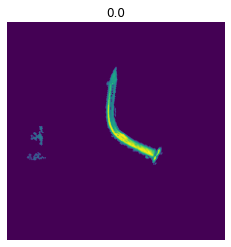

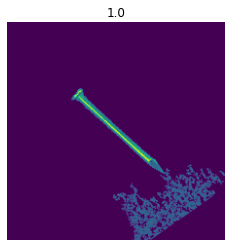

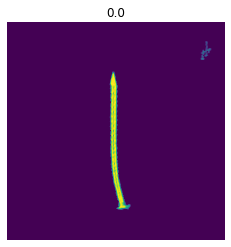

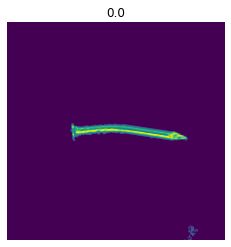

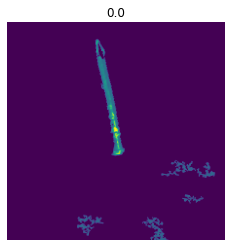

In [14]:
#check generators
x, y = training_generator.__getitem__(0)
for i in range(5):
    plt.figure()
    plt.imshow(x[i][:,:,0])
    plt.axis('off')
    plt.title(y[i]) #good = 1, bad = 0

In [15]:
#load pretrained ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

m = ResNet50V2()
# connect to input and output of existing model
# dense = Dense(500, activation='relu')(m.layers[-2].output)
# act = Dense(1, activation='sigmoid')(dense)

act = Dense(1, activation='sigmoid')(m.layers[-1].output)

m2 = Model(inputs=m.input, outputs=[act])
m2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [16]:
#freeze added layers for 5 epochs of warm-up
for layer in m2.layers:
    if layer.name in ['dense']:
        layer.trainable = True
    else:
        layer.trainable = False
m2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
m2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [17]:
history_00 = m2.fit_generator(generator=training_generator, 
                          validation_data=validation_generator, 
                          epochs=10, 
                          verbose=1, 
                          workers=8)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 2 steps
Epoch 1/10
7/7 [==============================] - 13s 2s/step - loss: 0.6931 - accuracy: 0.5214 - val_loss: 0.6946 - val_accuracy: 0.4000
Epoch 2/10
7/7 [==============================] - 8s 1s/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6911 - val_accuracy: 0.5500
Epoch 3/10
7/7 [==============================] - 8s 1s/step - loss: 0.6930 - accuracy: 0.5571 - val_loss: 0.6899 - val_accuracy: 0.5500
Epoch 4/10
7/7 [==============================] - 8s 1s/step - loss: 0.6928 - accuracy: 0.5643 - val_loss: 0.6912 - val_accuracy: 0.5750
Epoch 5/10
7/7 [==============================] - 8s 1s/step - loss: 0.6922 - accuracy: 0.6000 - val_loss: 0.6902 - val_accuracy: 0.6250
Epoch 6/10
7/7 [==============================] - 8s 1s/step - loss: 0.6918 - accuracy: 0.6500 - val_loss: 0.6882 - val_accuracy: 0.7000
Epoch 7/10


## Model training

In [18]:
#unfreeze added 2nd last layer
m2.save('200306_model_warmup.h5')
with open("200306_model_warmup_history.pkl", 'wb') as f:
    pickle.dump(history_00.history, f)  
for layer in m2.layers:
    if layer.name in ['dense', 'probs']:
        layer.trainable = True
    else:
        layer.trainable = False
m2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
m2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [19]:
# checkpoint to save highest validation accuracy only
filepath = "checkpoint/weights-improvement-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

In [20]:
history_01 = m2.fit_generator(generator=training_generator, 
                             validation_data=validation_generator, 
                             epochs=50, 
                             verbose=1, 
                             workers=8,
                             callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 2 steps
Epoch 1/50
6/7 [========================>.....] - ETA: 1s - loss: 0.6896 - accuracy: 0.6167
Epoch 00001: val_accuracy improved from -inf to 0.65000, saving model to checkpoint/weights-improvement-01.h5
7/7 [==============================] - 13s 2s/step - loss: 0.6894 - accuracy: 0.6143 - val_loss: 0.6874 - val_accuracy: 0.6500
Epoch 2/50
6/7 [========================>.....] - ETA: 0s - loss: 0.6844 - accuracy: 0.7417
Epoch 00002: val_accuracy did not improve from 0.65000
7/7 [==============================] - 8s 1s/step - loss: 0.6839 - accuracy: 0.7571 - val_loss: 0.6871 - val_accuracy: 0.6000
Epoch 3/50
6/7 [========================>.....] - ETA: 0s - loss: 0.6783 - accuracy: 0.7667
Epoch 00003: val_accuracy did not improve from 0.65000
7/7 [==============================] - 8s 1s/step - loss: 0.6778 - accuracy: 0.7500 - val_loss: 0.6842 - val_accuracy: 0.6500
Epoch 4/50
6/7 [===================

Epoch 29/50
6/7 [========================>.....] - ETA: 0s - loss: 0.6099 - accuracy: 0.7750
Epoch 00029: val_accuracy did not improve from 0.92500
7/7 [==============================] - 8s 1s/step - loss: 0.6029 - accuracy: 0.8000 - val_loss: 0.5882 - val_accuracy: 0.8250
Epoch 30/50
6/7 [========================>.....] - ETA: 0s - loss: 0.5959 - accuracy: 0.8250
Epoch 00030: val_accuracy did not improve from 0.92500
7/7 [==============================] - 8s 1s/step - loss: 0.5965 - accuracy: 0.8214 - val_loss: 0.5886 - val_accuracy: 0.8500
Epoch 31/50
6/7 [========================>.....] - ETA: 0s - loss: 0.5781 - accuracy: 0.8583
Epoch 00031: val_accuracy did not improve from 0.92500
7/7 [==============================] - 8s 1s/step - loss: 0.5766 - accuracy: 0.8571 - val_loss: 0.5728 - val_accuracy: 0.8750
Epoch 32/50
6/7 [========================>.....] - ETA: 0s - loss: 0.5822 - accuracy: 0.8417
Epoch 00032: val_accuracy did not improve from 0.92500
7/7 [=========================

In [21]:
with open("200306_model_01.pkl", 'wb') as f:
    pickle.dump(history_01.history, f)  

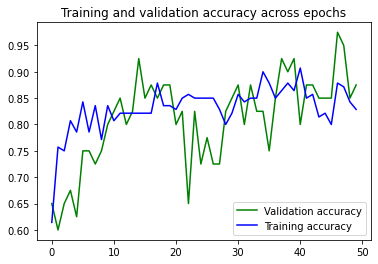

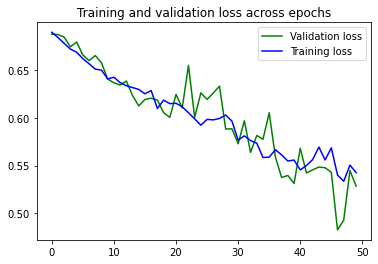

In [39]:
plot_history(history_01)

__Loss of both validation and training is still dropping->can be further optimized.__

In [37]:
history_02 = m2.fit_generator(generator=training_generator, 
                             validation_data=validation_generator, 
                             epochs=50, 
                             verbose=1, 
                             workers=8,
                             callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 2 steps
Epoch 1/50
6/7 [========================>.....] - ETA: 0s - loss: 0.5363 - accuracy: 0.8583
Epoch 00001: val_accuracy did not improve from 0.97500
7/7 [==============================] - 9s 1s/step - loss: 0.5335 - accuracy: 0.8643 - val_loss: 0.4845 - val_accuracy: 0.9500
Epoch 2/50
6/7 [========================>.....] - ETA: 0s - loss: 0.5167 - accuracy: 0.8917
Epoch 00002: val_accuracy did not improve from 0.97500
7/7 [==============================] - 8s 1s/step - loss: 0.5197 - accuracy: 0.8857 - val_loss: 0.5191 - val_accuracy: 0.8750
Epoch 3/50
6/7 [========================>.....] - ETA: 0s - loss: 0.5244 - accuracy: 0.9083
Epoch 00003: val_accuracy did not improve from 0.97500
7/7 [==============================] - 8s 1s/step - loss: 0.5277 - accuracy: 0.9000 - val_loss: 0.5133 - val_accuracy: 0.8500
Epoch 4/50
6/7 [========================>.....] - ETA: 0s - loss: 0.5234 - accuracy: 0.8833

Epoch 30/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4763 - accuracy: 0.8833
Epoch 00030: val_accuracy did not improve from 1.00000
7/7 [==============================] - 8s 1s/step - loss: 0.4715 - accuracy: 0.8929 - val_loss: 0.4364 - val_accuracy: 0.9500
Epoch 31/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4487 - accuracy: 0.9167
Epoch 00031: val_accuracy did not improve from 1.00000
7/7 [==============================] - 8s 1s/step - loss: 0.4451 - accuracy: 0.9214 - val_loss: 0.4525 - val_accuracy: 0.9000
Epoch 32/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4577 - accuracy: 0.9167
Epoch 00032: val_accuracy did not improve from 1.00000
7/7 [==============================] - 8s 1s/step - loss: 0.4555 - accuracy: 0.9214 - val_loss: 0.4486 - val_accuracy: 0.9250
Epoch 33/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4951 - accuracy: 0.8417
Epoch 00033: val_accuracy did not improve from 1.00000
7/7 [=========================

In [41]:
with open("200306_model_02.pkl", 'wb') as f:
    pickle.dump(history_02.history, f)  

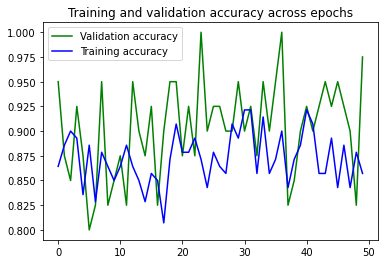

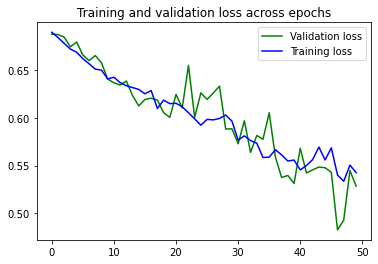

In [40]:
plot_history(history_02)

__Loss of both validation and training is still dropping->can be further optimized. Modify checkpoints to avoid missing models with very high accuracy and minimal overfitting__

In [43]:
# checkpoint to save all validation accuracy only
filepath = "checkpoint/weights-improvement-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=False,
                             mode='max')
callbacks_list = [checkpoint]

In [44]:
history_03 = m2.fit_generator(generator=training_generator, 
                             validation_data=validation_generator, 
                             epochs=50, 
                             verbose=1, 
                             workers=8,
                             callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 2 steps
Epoch 1/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4566 - accuracy: 0.8667
Epoch 00001: saving model to checkpoint/weights-improvement-01.h5
7/7 [==============================] - 9s 1s/step - loss: 0.4556 - accuracy: 0.8714 - val_loss: 0.4585 - val_accuracy: 0.8250
Epoch 2/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4547 - accuracy: 0.8750
Epoch 00002: saving model to checkpoint/weights-improvement-02.h5
7/7 [==============================] - 9s 1s/step - loss: 0.4470 - accuracy: 0.8857 - val_loss: 0.4070 - val_accuracy: 0.9250
Epoch 3/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4681 - accuracy: 0.8583
Epoch 00003: saving model to checkpoint/weights-improvement-03.h5
7/7 [==============================] - 9s 1s/step - loss: 0.4648 - accuracy: 0.8643 - val_loss: 0.3989 - val_accuracy: 0.9500
Epoch 4/50
6/7 [========================>.....] - ETA: 0s 

6/7 [========================>.....] - ETA: 0s - loss: 0.4246 - accuracy: 0.8833
Epoch 00029: saving model to checkpoint/weights-improvement-29.h5
7/7 [==============================] - 9s 1s/step - loss: 0.4242 - accuracy: 0.8857 - val_loss: 0.3604 - val_accuracy: 0.9500
Epoch 30/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4970 - accuracy: 0.7750
Epoch 00030: saving model to checkpoint/weights-improvement-30.h5
7/7 [==============================] - 9s 1s/step - loss: 0.4780 - accuracy: 0.8000 - val_loss: 0.3148 - val_accuracy: 1.0000
Epoch 31/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4432 - accuracy: 0.8500
Epoch 00031: saving model to checkpoint/weights-improvement-31.h5
7/7 [==============================] - 9s 1s/step - loss: 0.4522 - accuracy: 0.8500 - val_loss: 0.3788 - val_accuracy: 0.9250
Epoch 32/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4720 - accuracy: 0.8250
Epoch 00032: saving model to checkpoint/weights-improvement-32.h

In [46]:
with open("200306_model_03.pkl", 'wb') as f:
    pickle.dump(history_03.history, f)  

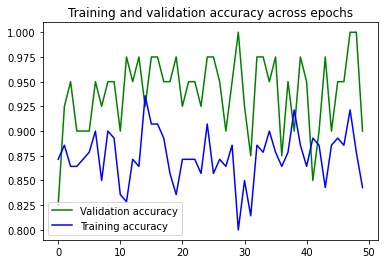

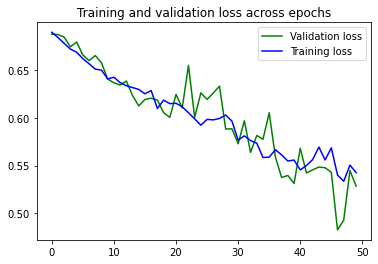

In [45]:
plot_history(history_03)

__The loss is still decreasing but the accuracy is not changing significantly. Training further is not necessary. The best model that has the best bias-variance balance is at the 9th epoch where the training accuracy = 0.9333 and the validation accuracy = 0.95.__
